DOWNLOAD - EXTRACT

In [1]:
import os, zipfile, requests, shutil

from pathlib import Path

# download and extract the dataset
DATA_DIR = Path("../data/raw")
DATA_DIR.mkdir(parents=True, exist_ok=True)

url = "https://www.kaggle.com/api/v1/datasets/download/nandanp6/cataract-image-dataset"
local_zip = DATA_DIR / "archive.zip"

if not local_zip.exists():
    print("Downloading dataset...")
    r = requests.get(url, stream=True)
    with open(local_zip, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    
    print("Done!")

In [2]:
import glob
import pandas as pd
from PIL import Image
from tqdm import tqdm

# define the dataset path
dataset_path = DATA_DIR / "processed_images/"

# generate the image paths and labels & split them into train and test sets
data = []
for split in ['train', 'test']:
    for label in ['normal', 'cataract']:
        folder_path = os.path.join(dataset_path, split, label)
        image_paths = glob.glob(os.path.join(folder_path, '*.png'))
        for img_path in image_paths:
            data.append({'path': img_path, 'label': 0 if label == 'normal' else 1, 'split': split})

# create & shuffle the DataFrame
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

# display the first few rows
print(df.head())

                                                path  label  split
0  ..\data\raw\processed_images\test\cataract\ima...      1   test
1  ..\data\raw\processed_images\train\normal\imag...      0  train
2  ..\data\raw\processed_images\train\normal\imag...      0  train
3  ..\data\raw\processed_images\train\cataract\im...      1  train
4  ..\data\raw\processed_images\test\cataract\ima...      1   test


INSPECT DATA

In [3]:
# corruption check
def validate_images(df):
    valid_paths = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            img = Image.open(row['path'])
            img.verify()  # Verify that it is, in fact, an image
            valid_paths.append(True)
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image: {row['path']}")
            valid_paths.append(False)
    return valid_paths

#  add a column to the DataFrame indicating whether the image is valid or not
df['is_valid'] = validate_images(df)
# display the count of valid vs invalid images
print(df['is_valid'].value_counts())

# yeet invalid images
df = df[df['is_valid']].drop(columns=['is_valid'])

100%|██████████| 612/612 [00:00<00:00, 1232.21it/s]

is_valid
True    612
Name: count, dtype: int64


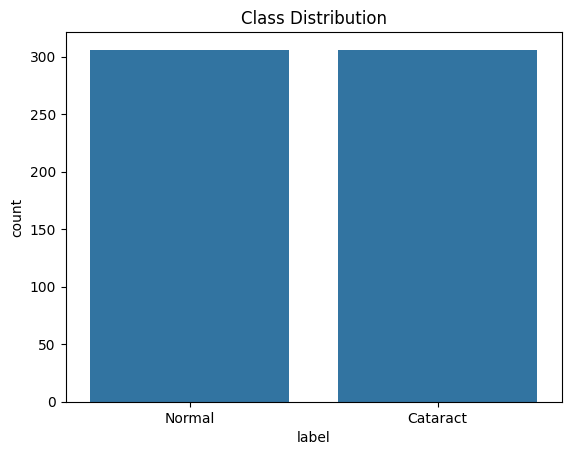

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xticks([0, 1], ['Normal', 'Cataract'])
plt.show()

In [5]:
# get image dimsensions
def get_image_dimensions(path):
    with Image.open(path) as img:
        return img.size

# apply the function to get dimensions & display most common sizes
df['dimensions'] = df['path'].apply(get_image_dimensions)
print(df['dimensions'].value_counts().head())

dimensions
(1000, 667)     16
(1600, 1067)     8
(493, 335)       8
(1500, 1001)     7
(1091, 727)      7
Name: count, dtype: int64


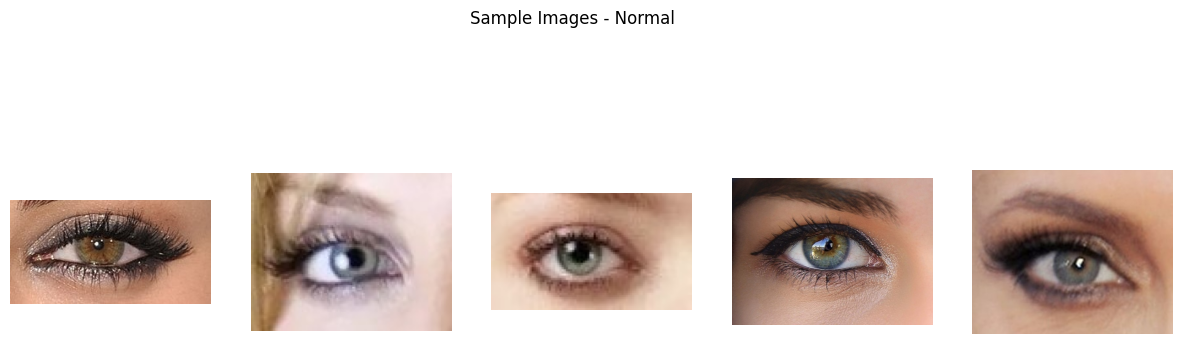

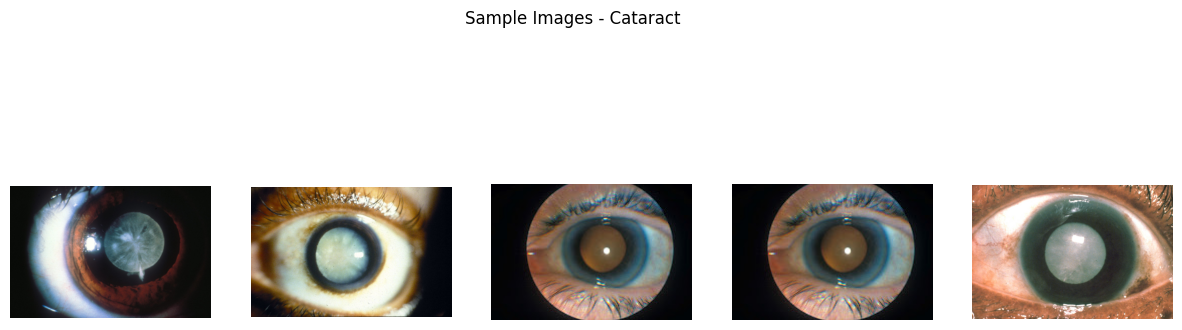

In [6]:
import matplotlib.pyplot as plt

# displaying some samples
def display_samples(df, label, num_samples=5):
    sample_paths = df[df['label'] == label]['path'].sample(num_samples).values
    plt.figure(figsize=(15,5))
    for i, path in enumerate(sample_paths):
        img = Image.open(path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - {"Cataract" if label == 1 else "Normal"}')
    plt.show()

# displaying for both classes
display_samples(df, label=0)
display_samples(df, label=1)